# 3.2 Neural Network Multi-Layer Perceptron Model

kernel = audio8_2_tf \
audio8_2_tf_requirements.txt

Structure largely follows Keras examples 
* https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb

## To Run


## Changes
* 8 Fixed hyperparameter tuning on MLP 
* 7 Add the CNN model, refactored,from PyTorch to TensorFlow
* 6 Automated hyperparameter estimation on MLP
* 5 Added the gender and age categorical variables as inputs
* 4 Added other MFCC metrics as numerical features from my preprocess script
* 3 added MFCC from my preprocessing scripts, added classification and class-imbalance metrics and performance improved to 80%+ accuracy
* 2 used MFCC calculated from the SAIE dataset from the method given in the script


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [2]:
tf.__version__

'2.17.0'

In [3]:
import librosa
from pydub import AudioSegment
import soundfile as sf
import ffmpeg
from IPython.display import Audio

C:\Users\GGMachines_Gaming\.conda\envs\audio8_2_tf\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
import pandas as pd
import numpy as np
import os

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
librosa.__version__

'0.10.2.post1'

In [8]:
import keras_tuner as kt

## File inputs and GLOBAL VARIABLES

In [9]:
#file_class=pd.read_csv('file_class.csv',index_col=0) #"C:\Users\GGMachines_Gaming\Documents\voxpop\file_class.df"

In [10]:
CWD=os.getcwd()
print(CWD)

C:\Users\GGMachines_Gaming\Documents\voxpop


In [11]:
INPUT_DIRECTORY=CWD

In [12]:
INPUT_DIRECTORY

'C:\\Users\\GGMachines_Gaming\\Documents\\voxpop'

In [13]:
#INPUT_DIRECTORY='C:\\Users\\GGMachines_Gaming\\Documents\\voxpop\\' #i9 machine

In [14]:
TRAIN_TEST_SPLIT = 0.80

In [15]:
# Neural network training run parameters
EPOCHS=20
BATCH_SIZE=32

In [16]:
## Used in versions 1,2 instead of the pickle preprocessing output

# file_class=pd.read_csv('file_class.csv',index_col=0) #"C:\Users\GGMachines_Gaming\Documents\voxpop\file_class.df"
# file_class.shape

In [17]:
platform=os.name
print(platform)

nt


In [18]:
if (platform=='nt'):
    SUBDIR="\\sample_output_directory\\"
print(SUBDIR)

\sample_output_directory\


In [19]:
def retrieve_file(county):
    all_files=os.listdir(INPUT_DIRECTORY+SUBDIR)
    pkl_files = [f for f in all_files if f.endswith('.pkl')]
    #print(pkl_files)
    filtered_files = [file for file in pkl_files if county in file]
    #print(filtered_files)
    most_recent_file=filtered_files[-1]
    #print(most_recent_file)
    return most_recent_file

In [20]:
retrieve_file('DUB')

'20240721_0000_DUB_features.pkl'

In [21]:
retrieve_file('ANT')

'20240721_0013_ANT_features.pkl'

In [22]:
'''
all_files=os.listdir(cwd+subdir)
pkl_files = [f for f in all_files if f.endswith('.pkl')]
print(pkl_files)
filtered_files = [file for file in pkl_files if 'DUB' in file]
print(filtered_files)
most_recent_file=filtered_files[-1]
print(most_recent_file)
'''

"\nall_files=os.listdir(cwd+subdir)\npkl_files = [f for f in all_files if f.endswith('.pkl')]\nprint(pkl_files)\nfiltered_files = [file for file in pkl_files if 'DUB' in file]\nprint(filtered_files)\nmost_recent_file=filtered_files[-1]\nprint(most_recent_file)\n"

In [23]:
dub_df=pd.read_pickle(INPUT_DIRECTORY+SUBDIR+retrieve_file('DUB'))

In [24]:
#dub_df = pd.read_pickle('C:\\Users\\GGMachines_Gaming\\Documents\\voxpop\\sample_output_directory\\20240721_0000_DUB_features.pkl') #i9 directory

In [25]:
dub_df[0:3]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2
0,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_A...,DUB_Artane_M_20,DUB,Artane,None,None,M,20,81.63,0,0,DUB_Artane_M_20_Rec_0_Sample_0.wav,"[1.5543122e-15, 3.330669e-15, 3.5527137e-15, 3...","[[-45.312862, -45.312862, -20.940594, -15.0561...",22050,"[[-655.949, -615.1495, -328.68915, -242.04138,...","[[49.801403, 49.801403, 49.801403, 49.801403, ...","[[-30.38227, -30.38227, -30.38227, -30.38227, ..."
1,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_A...,DUB_Artane_M_20,DUB,Artane,None,None,M,20,81.63,0,1,DUB_Artane_M_20_Rec_0_Sample_1.wav,"[-0.008644444, -0.01465759, -0.012110229, 0.00...","[[-34.0381, -32.152866, -36.18184, -49.078957,...",22050,"[[-280.54608, -219.32281, -217.8543, -227.0891...","[[16.633562, 16.633562, 16.633562, 16.633562, ...","[[-3.0967958, -3.0967958, -3.0967958, -3.09679..."
2,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_A...,DUB_Artane_M_20,DUB,Artane,None,None,M,20,81.63,0,2,DUB_Artane_M_20_Rec_0_Sample_2.wav,"[-0.013591497, -0.009562584, -0.0034573623, 0....","[[-26.495678, -26.199865, -34.241257, -27.4409...",22050,"[[-334.6902, -300.3063, -289.8084, -286.79123,...","[[5.437888, 5.437888, 5.437888, 5.437888, 5.43...","[[-1.3182307, -1.3182307, -1.3182307, -1.31823..."


In [26]:
antbel_df = pd.read_pickle(INPUT_DIRECTORY+SUBDIR+retrieve_file('ANT'))

In [27]:
#antbel_df = pd.read_pickle('C:\\Users\\GGMachines_Gaming\\Documents\\voxpop\\sample_output_directory\\20240721_0013_ANT_features.pkl') #i9 directory

In [28]:
antbel_df[0:3]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2
0,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,0,0,ANT_Antrim_R1_F_20_Rec_0_Sample_0.wav,"[-3.259629e-09, -1.9790605e-09, -1.8626451e-09...","[[-35.601192, -23.076942, -25.175114, -30.8771...",22050,"[[-494.3632, -314.76587, -256.5209, -248.23921...","[[22.54509, 22.54509, 22.54509, 22.54509, 22.5...","[[-13.363751, -13.363751, -13.363751, -13.3637..."
1,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,0,1,ANT_Antrim_R1_F_20_Rec_0_Sample_1.wav,"[-0.063719966, 0.018594107, 0.042440787, 0.011...","[[-24.939114, -19.037073, -35.540073, -40.6882...",22050,"[[-200.87267, -189.22813, -205.93425, -217.350...","[[1.7263998, 1.7263998, 1.7263998, 1.7263998, ...","[[8.442614, 8.442614, 8.442614, 8.442614, 8.44..."
2,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,0,2,ANT_Antrim_R1_F_20_Rec_0_Sample_2.wav,"[-0.009588398, -0.029184137, -0.023096263, -0....","[[-12.003866, -22.771717, -25.912066, -27.5487...",22050,"[[-269.9958, -209.71855, -199.9971, -192.51334...","[[7.1880474, 7.1880474, 7.1880474, 7.1880474, ...","[[-7.412616, -7.412616, -7.412616, -7.412616, ..."


## Reset recording numbers to avoid duplicates

In [29]:
recordings_count=dub_df['recording num'].max()
recordings_count

166

In [30]:
#Increase the recording number in the 2nd dataframe so that there are no duplicates
antbel_df['recording num']=dub_df['recording num']+recordings_count
antbel_df['recording num']

0       166
1       166
2       166
3       166
4       166
       ... 
6489    237
6490    237
6491    237
6492    237
6493    237
Name: recording num, Length: 6494, dtype: object

## Merge the DataFrames

In [31]:
# Concatenate the DataFrames
all_df= pd.concat([antbel_df, dub_df], ignore_index=True)

In [32]:
all_df.shape

(21594, 18)

In [33]:
all_df.iloc[0:4]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2
0,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,166,0,ANT_Antrim_R1_F_20_Rec_0_Sample_0.wav,"[-3.259629e-09, -1.9790605e-09, -1.8626451e-09...","[[-35.601192, -23.076942, -25.175114, -30.8771...",22050,"[[-494.3632, -314.76587, -256.5209, -248.23921...","[[22.54509, 22.54509, 22.54509, 22.54509, 22.5...","[[-13.363751, -13.363751, -13.363751, -13.3637..."
1,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,166,1,ANT_Antrim_R1_F_20_Rec_0_Sample_1.wav,"[-0.063719966, 0.018594107, 0.042440787, 0.011...","[[-24.939114, -19.037073, -35.540073, -40.6882...",22050,"[[-200.87267, -189.22813, -205.93425, -217.350...","[[1.7263998, 1.7263998, 1.7263998, 1.7263998, ...","[[8.442614, 8.442614, 8.442614, 8.442614, 8.44..."
2,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,166,2,ANT_Antrim_R1_F_20_Rec_0_Sample_2.wav,"[-0.009588398, -0.029184137, -0.023096263, -0....","[[-12.003866, -22.771717, -25.912066, -27.5487...",22050,"[[-269.9958, -209.71855, -199.9971, -192.51334...","[[7.1880474, 7.1880474, 7.1880474, 7.1880474, ...","[[-7.412616, -7.412616, -7.412616, -7.412616, ..."
3,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,166,3,ANT_Antrim_R1_F_20_Rec_0_Sample_3.wav,"[-0.02926175, -0.03246651, -0.03447114, -0.032...","[[-33.829704, -37.727036, -24.553106, -31.8029...",22050,"[[-319.19656, -307.64944, -314.54547, -295.997...","[[9.711183, 9.711183, 9.711183, 9.711183, 9.71...","[[-0.45292982, -0.45292982, -0.45292982, -0.45..."


In [34]:
# One-hot encoding: Put one column in for every value of the categorical variables

all_df = pd.get_dummies(all_df, columns=['genders','ages'],prefix=[None,None])

In [35]:
all_df.iloc[0:4,-16:-1]

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70
0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False


## Merge the samples with counties=ANT and BEL to give a common Antrim and Belfast dataset

In [36]:
counties=all_df['counties']

In [37]:
all_df['counties'] = all_df['counties'].replace({'ANT': 'ANTBEL', 'BEL': 'ANTBEL'})

In [38]:
all_df['counties'].value_counts()

counties
DUB       15100
ANTBEL     6494
Name: count, dtype: int64

In [39]:
print(all_df['counties'].shape)

(21594,)


## Replace counties with a binary value

In [40]:
all_df['y'] = all_df['counties'].replace({'ANTBEL':1, 'DUB': 0})

C:\Users\GGMachines_Gaming\AppData\Local\Temp\ipykernel_34068\3374583436.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df['y'] = all_df['counties'].replace({'ANTBEL':1, 'DUB': 0})


In [41]:
all_df['y']

0        1
1        1
2        1
3        1
4        1
        ..
21589    0
21590    0
21591    0
21592    0
21593    0
Name: y, Length: 21594, dtype: int64

In [42]:
all_df['y'].value_counts()

y
0    15100
1     6494
Name: count, dtype: int64

## Split into train and test datasets - make sure speakers are not split between them

In [43]:
# Count the unique recording values, then shuffle the unique values
unique_recordings = all_df['recording num'].unique()
np.random.shuffle(unique_recordings)  

# Determine the split index
split_index = int(len(unique_recordings) * TRAIN_TEST_SPLIT)
print(split_index)

190


In [44]:
unique_recordings

array([223, 142, 232, 173, 136, 41, 37, 219, 198, 11, 34, 85, 131, 222,
       152, 155, 6, 174, 73, 59, 44, 210, 24, 55, 214, 32, 143, 182, 94,
       220, 160, 225, 103, 228, 192, 117, 48, 16, 119, 92, 102, 236, 191,
       128, 75, 181, 164, 140, 22, 134, 30, 105, 40, 208, 166, 229, 234,
       18, 65, 0, 227, 141, 221, 171, 139, 186, 231, 111, 151, 163, 180,
       138, 201, 12, 127, 26, 50, 101, 54, 170, 144, 196, 216, 63, 83,
       147, 49, 70, 120, 172, 156, 169, 218, 80, 153, 29, 97, 108, 95, 78,
       82, 161, 9, 193, 69, 7, 132, 68, 130, 167, 224, 177, 51, 215, 58,
       149, 88, 38, 137, 146, 162, 8, 202, 121, 99, 42, 64, 93, 5, 81, 61,
       113, 176, 76, 72, 183, 150, 213, 2, 107, 217, 207, 187, 39, 4, 21,
       159, 89, 226, 35, 87, 135, 14, 36, 189, 3, 31, 114, 122, 15, 237,
       46, 10, 157, 185, 45, 100, 47, 28, 194, 233, 19, 154, 133, 123,
       206, 104, 118, 116, 212, 13, 158, 20, 60, 175, 109, 179, 204, 115,
       106, 145, 52, 91, 66, 67, 74, 98, 25, 57, 

In [2]:
# Split the unique values into two sets for train and test datasets WITH DIFFERENT SPEAKERS IN EACH
recording_train = unique_recordings[:split_index]
recording_test = unique_recordings[split_index:]

NameError: name 'unique_recordings' is not defined

In [46]:
print(recording_train) # TRAIN portion of the randomly shuffled dataset

[223 142 232 173 136 41 37 219 198 11 34 85 131 222 152 155 6 174 73 59 44
 210 24 55 214 32 143 182 94 220 160 225 103 228 192 117 48 16 119 92 102
 236 191 128 75 181 164 140 22 134 30 105 40 208 166 229 234 18 65 0 227
 141 221 171 139 186 231 111 151 163 180 138 201 12 127 26 50 101 54 170
 144 196 216 63 83 147 49 70 120 172 156 169 218 80 153 29 97 108 95 78 82
 161 9 193 69 7 132 68 130 167 224 177 51 215 58 149 88 38 137 146 162 8
 202 121 99 42 64 93 5 81 61 113 176 76 72 183 150 213 2 107 217 207 187
 39 4 21 159 89 226 35 87 135 14 36 189 3 31 114 122 15 237 46 10 157 185
 45 100 47 28 194 233 19 154 133 123 206 104 118 116 212 13 158 20 60 175
 109 179 204 115 106]


In [47]:
print(recording_test) # TEST portion of the randomly shuffled dataset

[145 52 91 66 67 74 98 25 57 71 124 178 199 129 125 200 84 211 43 86 190
 33 235 165 27 205 184 110 126 17 148 79 203 77 197 188 195 96 53 209 62 1
 90 230 168 23 56 112]


In [48]:
# Create two new DataFrames based on the split unique values
train_df = all_df[all_df['recording num'].isin(recording_train)].reset_index(drop=True)
test_df = all_df[all_df['recording num'].isin(recording_test)].reset_index(drop=True)

In [49]:
train_df.shape

(17181, 33)

In [50]:
test_df.shape

(4413, 33)

## Inspect MFCCx features

In [51]:
# Each individual MFCC shape
train_df['mfcc'][0].shape

(20, 44)

In [52]:
# Full array of MFCC values
train_df['mfcc'].shape

(17181,)

In [53]:
X_train = np.stack((train_df['mfcc'],train_df['mfcc_delta'],train_df['mfcc_delta_2']),axis=-1)

In [54]:
train_df['mfcc'].shape

(17181,)

In [55]:
type(train_df['mfcc'])

pandas.core.series.Series

In [56]:
type(train_df['mfcc'][0])

numpy.ndarray

In [57]:
train_df['mfcc'][0].shape

(20, 44)

In [58]:
train_df['mfcc']

0        [[-494.3632, -314.76587, -256.5209, -248.23921...
1        [[-200.87267, -189.22813, -205.93425, -217.350...
2        [[-269.9958, -209.71855, -199.9971, -192.51334...
3        [[-319.19656, -307.64944, -314.54547, -295.997...
4        [[-238.38216, -228.49149, -256.09305, -273.210...
                               ...                        
17176    [[-110.30995, -99.04926, -126.198555, -136.179...
17177    [[-97.73651, -89.979546, -113.11529, -134.1764...
17178    [[-239.09358, -160.47281, -144.84918, -154.863...
17179    [[-87.451416, -108.45021, -148.85347, -161.430...
17180    [[-170.16429, -178.88602, -222.11624, -225.288...
Name: mfcc, Length: 17181, dtype: object

In [59]:
train_df['mfcc'][0][0]

array([-494.3632 , -314.76587, -256.5209 , -248.23921, -253.03188,
       -255.51733, -248.05202, -232.95198, -219.96217, -142.84169,
        -97.36846, -110.77999, -132.57796, -174.49683, -258.99118,
       -296.77695, -227.69757, -172.99887, -191.70612, -218.03659,
       -223.80177, -241.4747 , -248.62724, -224.09459, -206.40266,
       -212.6678 , -253.71323, -299.12943, -224.64539, -194.39392,
       -214.50746, -199.5038 , -175.75398, -197.1167 , -248.56822,
       -264.3485 , -266.5907 , -286.43826, -294.3691 , -290.6586 ,
       -294.62158, -269.237  , -165.28264, -153.55447], dtype=float32)

In [60]:
type(train_df['mfcc'][0][0])

numpy.ndarray

In [61]:
train_df['mfcc'][0][0].shape

(44,)

In [62]:
X_train.shape

(17181, 3)

In [63]:
X_train[0][0].shape

(20, 44)

In [64]:
X_test = np.stack((test_df['mfcc'],test_df['mfcc_delta'],test_df['mfcc_delta_2']),axis=-1)

## Reshape MFCC features

In [65]:

def preprocess_features(feature: str ='mfcc', input: pd.DataFrame =train_df, output: pd.DataFrame ='X', ): 
    '''
    preprocess_features(feature: str ='mfcc', input: pd.DataFrame =train_df, output: pd.DataFrame ='X',)
    feature = numerical feature from dataset, usually 'mfcc', 'mfcc_delta', 'mfcc_delta_2'
    input = source dataset, usually train_df or test_df
    output = destination output dataframe
    '''
    flattened=[]
    flattened_index=input.index
    for j in input[feature]:
        flattened.append(np.array(j.flatten()))
    #print(len(flattened))
    output = pd.Series(flattened, index=flattened_index)
    output = np.stack(output.values)
    return output


In [66]:
mfcc_train=preprocess_features('mfcc')
print(mfcc_train)
print(mfcc_train.shape)
print(type(mfcc_train))

[[-4.94363190e+02 -3.14765869e+02 -2.56520905e+02 ... -1.60376263e+00
  -3.11242390e+00 -1.56794906e+00]
 [-2.00872665e+02 -1.89228134e+02 -2.05934250e+02 ...  9.28223610e+00
   8.04540825e+00  1.06966095e+01]
 [-2.69995789e+02 -2.09718552e+02 -1.99997101e+02 ... -3.92313886e+00
  -7.42311621e+00 -5.33314514e+00]
 ...
 [-2.39093582e+02 -1.60472809e+02 -1.44849182e+02 ... -3.65712166e-01
  -8.62231541e+00 -7.36551952e+00]
 [-8.74514160e+01 -1.08450211e+02 -1.48853470e+02 ... -3.99238062e+00
  -2.72970438e+00 -2.40183997e+00]
 [-1.70164291e+02 -1.78886017e+02 -2.22116241e+02 ... -1.29232941e+01
  -1.03022346e+01 -5.41623688e+00]]
(17181, 880)
<class 'numpy.ndarray'>


In [67]:
mfcc_test=preprocess_features(feature='mfcc',input=test_df)
print(mfcc_test)
print(mfcc_test.shape)
print(type(mfcc_test))

[[-1.9258206e+02 -1.7897838e+02 -2.0269991e+02 ... -6.0020957e+00
  -8.5819588e+00 -7.9937773e+00]
 [-2.4248033e+02 -2.3579128e+02 -2.7496640e+02 ... -6.3402867e-01
   2.1134546e+00  5.8295670e+00]
 [-4.0104791e+02 -3.6778891e+02 -3.6861429e+02 ... -6.7300949e+00
  -3.7140150e+00 -3.3979897e+00]
 ...
 [-2.3622951e+02 -2.2657021e+02 -2.5364145e+02 ... -1.0759991e+01
  -1.2976841e+01 -6.3813190e+00]
 [-7.0539040e+01 -1.0354980e+02 -1.8674783e+02 ...  1.6289256e+00
  -7.9042464e-03  2.0488713e+00]
 [-4.3066998e+02 -3.8125369e+02 -3.5371768e+02 ... -3.0282297e+00
   1.8168622e-01  1.0387173e+00]]
(4413, 880)
<class 'numpy.ndarray'>


In [68]:
mfcc_delta_train=preprocess_features('mfcc_delta')
mfcc_delta_train[0:3]

array([[22.54509   , 22.54509   , 22.54509   , ..., -0.12745161,
        -0.12745161, -0.12745161],
       [ 1.7263998 ,  1.7263998 ,  1.7263998 , ...,  1.8224183 ,
         1.8224183 ,  1.8224183 ],
       [ 7.1880474 ,  7.1880474 ,  7.1880474 , ..., -0.73991925,
        -0.73991925, -0.73991925]], dtype=float32)

In [69]:
mfcc_delta_test=preprocess_features(feature='mfcc_delta',input=test_df)
mfcc_delta_test[0:3]

array([[  4.923385  ,   4.923385  ,   4.923385  , ...,  -1.9246106 ,
         -1.9246106 ,  -1.9246106 ],
       [-18.472893  , -18.472893  , -18.472893  , ...,   0.19279245,
          0.19279245,   0.19279245],
       [  2.9945495 ,   2.9945495 ,   2.9945495 , ...,   0.22773969,
          0.22773969,   0.22773969]], dtype=float32)

In [70]:
mfcc_delta_2_train=preprocess_features('mfcc_delta_2')
mfcc_delta_2_train[0:3]

array([[-1.3363751e+01, -1.3363751e+01, -1.3363751e+01, ...,
        -1.3258730e-04, -1.3258730e-04, -1.3258730e-04],
       [ 8.4426136e+00,  8.4426136e+00,  8.4426136e+00, ...,
        -4.2466238e-01, -4.2466238e-01, -4.2466238e-01],
       [-7.4126158e+00, -7.4126158e+00, -7.4126158e+00, ...,
        -1.4199364e+00, -1.4199364e+00, -1.4199364e+00]], dtype=float32)

In [71]:
mfcc_delta_2_test=preprocess_features(feature='mfcc_delta_2',input=test_df)
mfcc_delta_2_test[0:3]

array([[ 0.21570802,  0.21570802,  0.21570802, ...,  0.9317962 ,
         0.9317962 ,  0.9317962 ],
       [ 4.094953  ,  4.094953  ,  4.094953  , ..., -0.27899605,
        -0.27899605, -0.27899605],
       [-2.5580301 , -2.5580301 , -2.5580301 , ..., -0.5966005 ,
        -0.5966005 , -0.5966005 ]], dtype=float32)

## Add ages and genders columns to train and test data

In [72]:
X_ages_train=train_df[[15,16,20,25,30,35,40,45,50,55,60,65,70]]

In [73]:
X_ages_train

,15,16,20,25,30,35,40,45,50,55,60,65,70
0,False,False,True,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17176,False,False,True,False,False,False,False,False,False,False,False,False,False
17177,False,False,True,False,False,False,False,False,False,False,False,False,False
17178,False,False,True,False,False,False,False,False,False,False,False,False,False
17179,False,False,True,False,False,False,False,False,False,False,False,False,False


In [74]:
X_ages_test = test_df[[15,16,20,25,30,35,40,45,50,55,60,65,70]]

In [75]:
X_ages_test

,15,16,20,25,30,35,40,45,50,55,60,65,70
0,False,False,False,True,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4408,False,False,True,False,False,False,False,False,False,False,False,False,False
4409,False,False,True,False,False,False,False,False,False,False,False,False,False
4410,False,False,True,False,False,False,False,False,False,False,False,False,False
4411,False,False,True,False,False,False,False,False,False,False,False,False,False


In [76]:
X_genders_train=train_df[['F','M']]

In [77]:
X_genders_test = test_df[['F','M']]

In [78]:
#X_train, X_test = mfcc_train, mfcc_test

In [79]:
#X_train=np.stack((mfcc_train, mfcc_delta_train, mfcc_delta_2_train), axis=-1)

In [80]:
#X_train=np.hstack((mfcc_train, mfcc_delta_train, mfcc_delta_2_train,X_genders_train))
#X_train.shape

In [81]:
X_train=np.hstack((mfcc_train, mfcc_delta_train, mfcc_delta_2_train,X_genders_train,X_ages_train))
X_train.shape

(17181, 2655)

In [82]:
#X_test=np.stack((mfcc_test, mfcc_delta_2_test, mfcc_delta_2_test), axis=-1)

In [83]:
#X_test2=np.hstack((mfcc_test, mfcc_delta_2_test, mfcc_delta_2_test,X_genders_test))

In [84]:
#X_test2.shape

In [85]:
X_test=np.hstack((mfcc_test, mfcc_delta_2_test, mfcc_delta_2_test,X_genders_test,X_ages_test))

In [86]:
X_test.shape

(4413, 2655)

In [87]:
# Check the total number of records in train and test is the same as in ANT and DUB dataframes
X_train.shape[0]+X_test.shape[0]

21594

In [88]:
X_genders_test.value_counts()

F      M    
False  True     2325
True   False    2088
Name: count, dtype: int64

In [89]:
X_test
print(X_test.shape)

(4413, 2655)


In [90]:
X_train.shape

(17181, 2655)

In [91]:
X_train[0:1]

array([[-494.3632 , -314.76587, -256.5209 , ...,    0.     ,    0.     ,
           0.     ]], dtype=float32)

In [92]:
y_train, y_test = train_df['y'], test_df['y'], 

In [93]:
print(y_train.shape)
y_train=np.array(y_train)
y_train

(17181,)


array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [94]:
print(y_test.shape)
y_test=np.array(y_test)

(4413,)


## Compute class weights

In [95]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights)

Class Weights: {0: 0.7126088759850684, 1: 1.675868123293016}


In [96]:
#scaler = StandardScaler()
#X_train_scaled  = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [97]:
ANTBEL_share=(y_train.sum()/y_train.shape[0])
DUB_share=1-ANTBEL_share
print("ANTBEL share = {:.2%}".format(ANTBEL_share))
print("DUB share = {:.2%}".format(DUB_share))

ANTBEL share = 29.84%
DUB share = 70.16%


In [98]:
#input_shape=(880,3) # MFCCs stacked vertically
#input_shape=(2642,) # MFCCs stacked horizontally alongside gender one-hot variables

input_shape=(2655,) # MFCCs stacked horizontally alongside gender and age one-hot variables


# Build Model for Autotuning MLP NN

In [99]:
# Add normalization and dropout

def build_model(hp,):
      
    model = keras.Sequential()
    
    model.add(layers.LayerNormalization(input_shape=input_shape))

    model.add(layers.Flatten(input_shape=input_shape))  # Adjust input shape according to your data
    
    # Tune the number of units in the first Dense layer
    layer1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=layer1, activation='relu'))
    
    #model.add(layers.Dropout(0.5))
    #if hp.Boolean("dropout"):
    #    model.add(layers.Dropout(rate=0.5))
        
    # Tune the number of units in the second Dense layer
    layer2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=layer2, activation='relu'))
    
    #model.add(layers.Dropout(0.5))
    # random chance of adding a dropout layer
    
    #if hp.Boolean("dropout"):
    #    model.add(layers.Dropout(rate=0.5))

    # Tune the number of units in the third Dense layer
    layer3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=layer3, activation='relu'))
    
    #if hp.Boolean("dropout"):
    #    model.add(layers.Dropout(rate=0.5))
    #model.add(layers.Dropout(0.5))
    
    if hp.Boolean("fourth_layer"):
    # Tune the number of units in the 4th Dense layer
        layer4 = hp.Int('units4', min_value=32, max_value=512, step=32)
        model.add(layers.Dense(units=layer4, activation='relu'))
    
    #model.add(layers.Dropout(0.5))
    
    #if hp.Boolean("dropout"):
    #    model.add(layers.Dropout(rate=0.5))
    
    model.add(layers.Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # Tune the learning rate for the optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [ ]:
'''
def build_model(hp,):
      
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))  # Adjust input shape according to your data

    # Tune the number of units in the first Dense layer
    layer1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=layer1, activation='relu'))

    # Tune the number of units in the second Dense layer
    layer2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=layer2, activation='relu'))

    # Tune the number of units in the third Dense layer
    layer3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=layer3, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # Tune the learning rate for the optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model
'''

In [ ]:
'''
def build_model(hp,):
      
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))  # Adjust input shape according to your data

    # Tune the number of units in the first Dense layer
    layer1 = hp.Int('units1', min_value=32, max_value=100, step=2)
    model.add(layers.Dense(units=layer1, activation='relu'))

    # Tune the number of units in the second Dense layer
    layer2 = hp.Int('units2', min_value=32, max_value=100, step=2)
    model.add(layers.Dense(units=layer2, activation='relu'))

    # Tune the number of units in the third Dense layer
    layer3 = hp.Int('units3', min_value=32, max_value=100, step=2)
    model.add(layers.Dense(units=layer3, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # Tune the learning rate for the optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model
'''

In [100]:
# keras tuner RandomSearch parameters 
MAX_TRIALS=5
EXECUTIONS_PER_TRIAL=3

In [101]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=MAX_TRIALS,  # Number of different models to try
    executions_per_trial=EXECUTIONS_PER_TRIAL,  # Number of times to train each model
    #directory='my_dir',
    directory=INPUT_DIRECTORY,
    project_name='mlp_randomsearch_4layers_nodrop'
)

C:\Users\GGMachines_Gaming\.conda\envs\audio8_2_tf\lib\site-packages\keras\src\layers\normalization\layer_normalization.py:122: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\GGMachines_Gaming\.conda\envs\audio8_2_tf\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [106]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
fourth_layer (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


In [103]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (17181, 2655)
X_test shape: (4413, 2655)
y_train shape: (17181,)
y_test shape: (4413,)


In [104]:
tuner.search(X_train, y_train, epochs=EPOCHS, class_weight=class_weights, verbose=2, validation_data=(X_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=MAX_TRIALS)[0]

print(f"""
The optimal number of units in the first densely-connected layer is {best_hps.get('units1')}.
The optimal number of units in the second densely-connected layer is {best_hps.get('units2')}.
The optimal number of units in the third densely-connected layer is {best_hps.get('units3')}.
The optimal number of units in the fourth densely-connected layer is present? {best_hps.get('fourth_layer')}.
The optimal number of units in the fourth densely-connected layer is {best_hps.get('units4')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 5 Complete [00h 01m 22s]
val_accuracy: 0.8433416485786438

Best val_accuracy So Far: 0.8570888837178549
Total elapsed time: 00h 09m 13s

The optimal number of units in the first densely-connected layer is 448.
The optimal number of units in the second densely-connected layer is 192.
The optimal number of units in the third densely-connected layer is 32.
The optimal number of units in the fourth densely-connected layer is present? True.
The optimal number of units in the fourth densely-connected layer is 96.
The optimal learning rate for the optimizer is 0.0001.



In [105]:
models=tuner.get_best_models(num_models=1)
best_model=models[0]
best_model.summary()

C:\Users\GGMachines_Gaming\.conda\envs\audio8_2_tf\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer_normalization             │ (None, 2655)           │         5,310 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2655)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 448)            │     1,189,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 192)            │        86,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,290,847 (4.92 MB)

 Trainable params: 1,290,847 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
tuner.results_summary()

Results summary
Results in C:\Users\GGMachines_Gaming\Documents\voxpop\mlp_randomsearch_4layers_nodrop
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
units1: 448
units2: 192
units3: 32
fourth_layer: True
learning_rate: 0.0001
units4: 96
Score: 0.8570888837178549

Trial 3 summary
Hyperparameters:
units1: 320
units2: 96
units3: 224
fourth_layer: True
learning_rate: 0.001
units4: 160
Score: 0.8530100385348002

Trial 4 summary
Hyperparameters:
units1: 64
units2: 192
units3: 224
fourth_layer: False
learning_rate: 0.0001
units4: 32
Score: 0.8433416485786438

Trial 0 summary
Hyperparameters:
units1: 64
units2: 128
units3: 160
fourth_layer: True
learning_rate: 0.01
units4: 32
Score: 0.8186419010162354

Trial 2 summary
Hyperparameters:
units1: 224
units2: 288
units3: 416
fourth_layer: True
learning_rate: 0.01
units4: 64
Score: 0.7721882263819376


In [ ]:
''' mlp_randomsearch_5_3
trial 5 Complete [00h 05m 35s]
val_accuracy: 0.8656761844952902

Best val_accuracy So Far: 0.8656761844952902
Total elapsed time: 00h 19m 31s

The optimal number of units in the first densely-connected layer is 448.
The optimal number of units in the second densely-connected layer is 352.
The optimal number of units in the third densely-connected layer is 512.
The optimal learning rate for the optimizer is 0.001.
'''

In [ ]:
''' mlp_randomsearch_7_3
Trial 7 Complete [00h 01m 39s]
val_accuracy: 0.8757333358128866

Best val_accuracy So Far: 0.8757333358128866
Total elapsed time: 00h 19m 49s

The optimal number of units in the first densely-connected layer is 64.
The optimal number of units in the second densely-connected layer is 32.
The optimal number of units in the third densely-connected layer is 416.
The optimal learning rate for the optimizer is 0.001.
'''

In [ ]:
''' intro_to_kt 20 trials of 5 each
Trial 20 Complete [00h 02m 56s]
val_accuracy: 0.8646399974822998

Best val_accuracy So Far: 0.8733257174491882
Total elapsed time: 01h 12m 13s

The optimal number of units in the first densely-connected layer is 60.
The optimal number of units in the second densely-connected layer is 42.
The optimal number of units in the third densely-connected layer is 48.
The optimal learning rate for the optimizer is 0.01.
'''


# Run the optimised MLP 

In [ ]:
units1: 448
units2: 192
units3: 32
fourth_layer: True
learning_rate: 0.0001
units4: 96
Score: 0.8570888837178549

In [108]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape,),
        
        tf.keras.layers.Dense(448, activation='relu'),
        tf.keras.layers.Dense(192, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(96, activation='relu'),
    
        tf.keras.layers.Dense(1, activation='sigmoid')  # Assuming binary classification
    ])

In [109]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy', metrics=['accuracy'])

In [110]:
history=model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, class_weight=class_weights, verbose=2, validation_data=(X_test, y_test))

Epoch 1/20
537/537 - 3s - 5ms/step - accuracy: 0.7902 - loss: 0.5193 - val_accuracy: 0.7720 - val_loss: 0.5006
Epoch 2/20
537/537 - 2s - 5ms/step - accuracy: 0.8403 - loss: 0.3432 - val_accuracy: 0.8069 - val_loss: 0.4348
Epoch 3/20
537/537 - 2s - 3ms/step - accuracy: 0.8500 - loss: 0.3137 - val_accuracy: 0.7786 - val_loss: 0.4796
Epoch 4/20
537/537 - 2s - 3ms/step - accuracy: 0.8625 - loss: 0.2869 - val_accuracy: 0.8144 - val_loss: 0.4799
Epoch 5/20
537/537 - 3s - 5ms/step - accuracy: 0.8741 - loss: 0.2694 - val_accuracy: 0.8208 - val_loss: 0.4023
Epoch 6/20
537/537 - 2s - 3ms/step - accuracy: 0.8806 - loss: 0.2496 - val_accuracy: 0.8310 - val_loss: 0.3932
Epoch 7/20
537/537 - 3s - 5ms/step - accuracy: 0.8942 - loss: 0.2235 - val_accuracy: 0.8298 - val_loss: 0.3840
Epoch 8/20
537/537 - 2s - 3ms/step - accuracy: 0.9059 - loss: 0.2022 - val_accuracy: 0.8307 - val_loss: 0.4078
Epoch 9/20
537/537 - 3s - 5ms/step - accuracy: 0.9171 - loss: 0.1794 - val_accuracy: 0.8217 - val_loss: 0.5230
E

In [111]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 2655)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 448)            │     1,189,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 192)            │        86,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 96)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,856,613 (14.71 MB)

 Trainable params: 1,285,537 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,571,076 (9.81 MB)

In [112]:
loss, accuracy = model.evaluate(X_test, y_test,verbose=2)
print(f'Test  Accuracy: {accuracy:.1%}')

138/138 - 0s - 1ms/step - accuracy: 0.8473 - loss: 0.5887
Test  Accuracy: 84.7%


In [113]:
from matplotlib.ticker import MaxNLocator

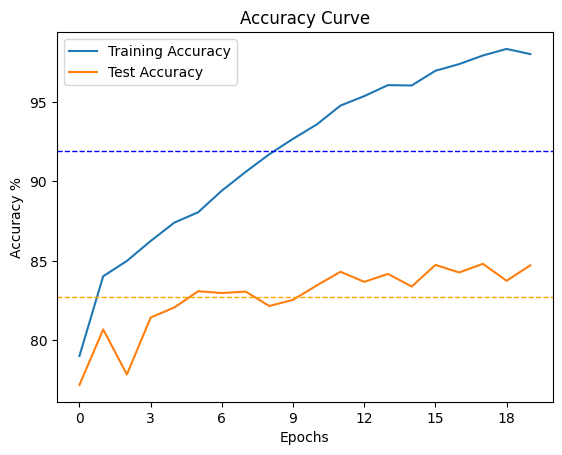

In [114]:
plt.figure()
plt.plot([acc * 100 for acc in history.history['accuracy']], label='Training Accuracy')
plt.plot([val_acc * 100 for val_acc in history.history['val_accuracy']], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.title('Accuracy Curve')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

mean_accuracy = np.mean(history.history['accuracy'])
mean_val_accuracy = np.mean(history.history['val_accuracy'])
plt.axhline(mean_accuracy * 100, color='blue', linestyle='--', linewidth=1, label=f'Mean Training Accuracy ({mean_accuracy*100:.2f}%)')
plt.axhline(mean_val_accuracy * 100, color='orange', linestyle='--', linewidth=1, label=f'Mean Validation Accuracy ({mean_val_accuracy*100:.2f}%)')

plt.show()

In [115]:
 # Generate predictions, 
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > DUB_share).astype(int)

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [116]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[2724  321]
 [ 344 1024]]


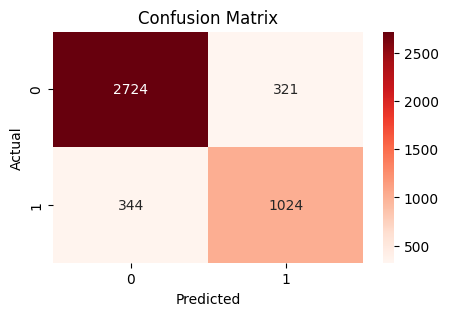

In [117]:
# Plot Confusion Matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 84.93%
Precision: 76.13%
Recall: 74.85%
F1 Score: 75.49%
AUC Score: 91.92%


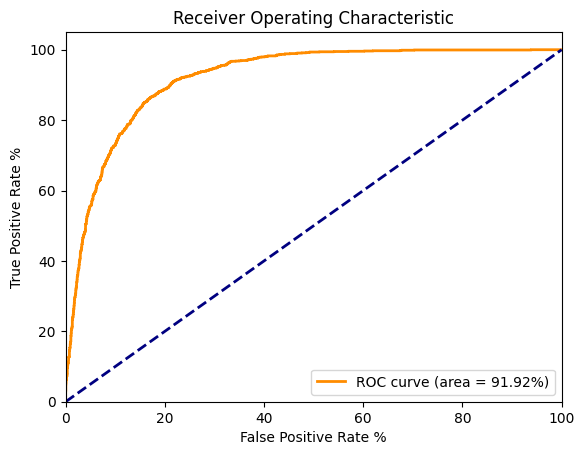

In [118]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')
print(f'F1 Score: {f1:.2%}')
# AUC Score and Curve
auc_score = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f'AUC Score: {auc_score:.2%}')
#
plt.figure()
plt.plot(fpr*100, tpr*100, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2%})')
plt.plot([0, 100], [0, 100], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 100])
plt.ylim([0.0, 105])
plt.xlabel('False Positive Rate %')
plt.ylabel('True Positive Rate %')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()